# Project 1: Thresholding and Blob tracking

## Overview

Written by Quentin Adolphe (qadolphe1@swarthmore.edu) and Cole Smith for our Swarthmore College Computer Vision course in 2023.

Taught by Visiting Assistant Professor of Engineering, Stephen Philips.
Coursework adapted from Matt Zucker, associate professor in the Engineering department at Swarthmore College.

For this project, we built a system that:

* thresholds a sequence of color or grayscale images to distinguish objects of interest from the background.
* applies morphological operators to the thresholded images in order to remove noise and imperfections.
* performs a connected components analysis to distinguish between separate objects, and to identify their locations in the image.
* tracks the connected components over time.

The last two items in the list above are collectively known as blob tracking.

Tennis video used for tracking: https://www.youtube.com/watch?v=IqK86B0Lagc


## Tasks

### Thresholding

This system will produce a thresholded binary image where the non-zero
pixels correspond to objects of interest (foreground), and the zero
pixels correspond to background. You will need to decide on some important
details of your thresholding approach.


#### Background subtraction and temporal averaging:

A useful technique is to compare the difference of each frame to a reference image:

~~~ Python
mask = cv2.absdiff(img_cur, img_ref).max(axis=2) > tau
~~~

*Temporal averaging*: In this approach, the
system looks at the difference between a given pixel value at some
location and the average intensity of that location over time. We take a temporal average by simply adding together multiple frames
and dividing by the number of frames:

~~~ Python
accum = np.zeros((h, w), dtype=np.float32)
cnt = 0

for frame in video:
    accum += frame
    cnt += 1
    
img_ref = np.clip(accum/cnt, 0, 255).astype(np.uint8)
~~~

Note the use of
[`numpy.clip`](https://numpy.org/doc/stable/reference/generated/numpy.clip.html)
to prevent overflow when converting back to the `numpy.uint8`
datatype.


### Morphological Operators

Apply morphological operators to thresholded frames to eliminate noise
and speckles.  OpenCV provides [`cv2.erode`](https://docs.opencv.org/master/d4/d86/group__imgproc__filter.html#gaeb1e0c1033e3f6b891a25d0511362aeb), [`cv2.dilate`](https://docs.opencv.org/master/d4/d86/group__imgproc__filter.html#ga4ff0f3318642c4f469d0e11f242f3b6c),
and [`cv2.morphologyEx`](https://docs.opencv.org/master/d4/d86/group__imgproc__filter.html#ga67493776e3ad1a3df63883829375201f) functions to implement these.  our goal here is to produce the best possible image to send into the next stage of the processing pipeline.

Here are some tips about which operator to use, when:

  * erosion gets rid of spurious foreground bits (e.g. "salt noise")
  
  * dilation gets rid of spurious background bits (e.g. "pepper noise")
  
  * opening/closing are good for "putting back" some of what
    erosion/dilation remove, which can be useful if you're doing
    special effects
    
  * you can also pair up erosions and dilations with *different*
    structuring elements - for instance, you could use erosion by a
    small shape to eliminate salt noise, followed by dilation by a
    larger shape to replace lost mass and merge nearby disconnected
    components...
    



### Connected components analysis

The OpenCV function [`cv2.findContours`](https://docs.opencv.org/master/d3/dc0/group__imgproc__shape.html#gadf1ad6a0b82947fa1fe3c3d497f260e0) retrieves the outlines of connected components of non-zero pixels. Applied to our thresholded
image, this corresponds to outlines of the tennis players. Some additional analysis of the contours yields information
such as the area, centroid, and principal axes of each connected
component.

### Tracking

Our system extracts the position of each object's centroid in
each frame and is able to track objects' trajectories over time by
associating the connected components in the current frame with those
of the previous frame (note that this is trivial in scenes containing
a single object, but can become very tricky in scenes with many
objects).

# Our Code

### Instructions

To run this code you must update the input_filename in the block below to accurately pull from where your source video is located. Once this is complete, running the notebook should run efficiently. 

## Code 

The block below was used to mount the notebook drive, import the necessary libraries we use, decalare the filename of the video to be analyzed, and contains code from the provided resize.ipynb by Professor Phillips. We also performed temporal averaging to obtain a representative background image, and display the obtained image at the end.

In [49]:
'''#### Temporal averaging to create image background across frames

from google.colab import drive
drive.mount('/content/drive') # Mount your own drive

##### UPDATE HERE #####
#input_filename = '/content/drive/MyDrive/CompVis/Project1/tennisrally(2)_resized.mp4'''

"#### Temporal averaging to create image background across frames\n\nfrom google.colab import drive\ndrive.mount('/content/drive') # Mount your own drive\n\n##### UPDATE HERE #####\n#input_filename = '/content/drive/MyDrive/CompVis/Project1/tennisrally(2)_resized.mp4"

In [50]:
import gdown

# Images go here. To add new images for analysis, get the proper ID from the google drive link
# and update accordingly with the correct name.
id_name_pairs = [ 
    ("1I95jPw4Dm5PbAcuwdCO5OuvNDAwRrtgx", "tennisrally(2)_resized.mp4"),
] 
for id, name, in id_name_pairs:
  url = f'https://drive.google.com/uc?id={id}'
  gdown.download(url, name, quiet=True)

input_filename = "tennisrally(2)_resized.mp4"

### Temporal averaging to create image background across frames

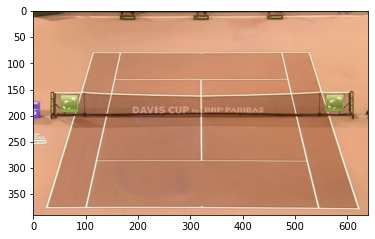

In [51]:
#######################

## imports 
import cv2
import numpy as np
import os
import sys
import time
import matplotlib.pyplot as plt

## Load in video, resized from Professor Zuckers helped notebook resize_video.ipynb

def get_num_frames(input_filename):

    cap = cv2.VideoCapture(input_filename)

    # try the fast way
    nframes = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
    height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
    fps = cap.get(cv2.CAP_PROP_FPS)

    if not fps > 1:
        # fps buggy sometimes
        fps = 30.0 

    if nframes > 1 and width > 1 and height > 1:
        # it worked
        return int(nframes), int(width), int(height), fps

    # the slow way
    cnt = 0
    
    while True:
        ok, frame = cap.read()
        if not ok or frame is None:
            break
        height, width = frame.shape[:2]
        cnt += 1

    return cnt, width, height, fps


if not os.path.exists(input_filename):
    print('error:', input_filename, 'does not exist')
    sys.exit(1)

# Create the output video
path_prefix, basename = os.path.split(input_filename)
basename, _ = os.path.splitext(basename)

# Get video properties
nframes, width, height, fps = get_num_frames(input_filename)

# Create output writer
fourcc, ext = (cv2.VideoWriter_fourcc('m', 'p', '4', 'v'), 'mp4')
output_filename = os.path.join(path_prefix, basename + '_tracked.' + ext)
writer = cv2.VideoWriter(output_filename, fourcc, fps, (width, height))

# Write out frames
accum = np.zeros((height, width,3), dtype=np.float32)
cnt = 0
cap = cv2.VideoCapture(input_filename)
frames = []
for frame_idx in range(nframes):
    ok, frame = cap.read()
    if not ok or frame is None:
        break

    frames.append(frame)
    frame_idx += 1
    accum += frame.astype(np.float32)
    cnt += 1


### background generation (temporal averaging)

img_ref = np.clip(accum/cnt, 0, 255).astype(np.uint8)

plt.imshow(img_ref)

The code below is partially adapted from the capture.ipynb notebook, including our own user defined function get_coordinates to obtain the coordinates of the centroids for each contour for later tracking, adapted from the get_region function provided, and the get_contour_info function provided bt Professor Phillips.

In [52]:
# width/color pairs for drawing white over black outlines
DRAW_OUTLINED = [ (3, (0, 0, 0)), (1, (255, 255, 255)) ]

def get_coordinates(filename):
    image = filename

    # Get the list of contours in the image. See OpenCV docs for
    # information about the arguments.
    contours, hierarchy = cv2.findContours(image, cv2.RETR_CCOMP,
                                           cv2.CHAIN_APPROX_SIMPLE)

    coords = []
    
    for contour in contours:

        # Compute some statistics about this contour.
        info = get_contour_info(contour)

        # Mean location, area, and basis vectors can be useful.
        area = info['area']
        mu = info['mean']
        coords.append(mu)
        #cv2.circle( display, make_point(mu), 1, (255, 0, 0),
        #                4, cv2.LINE_AA )
        
    plt.imshow(display)

    return coords


######################################################################
# Construct a tuple of ints from a numpy array

def make_point(arr):
    return tuple(np.round(arr).astype(int).flatten())

######################################################################
# Draw outlined text


######################################################################
#
# Compute moments and derived quantities such as mean, area, and
# basis vectors from a contour as returned by cv2.findContours.
#
# Feel free to use this function with attribution in your project 1
# code.
#
# Returns a dictionary.

def get_contour_info(c):

    # For more info, see
    #  - https://docs.opencv.org/master/dd/d49/tutorial_py_contour_features.html
    #  - https://en.wikipedia.org/wiki/Image_moment

    m = cv2.moments(c)

    s00 = m['m00']
    s10 = m['m10']
    s01 = m['m01']
    c20 = m['mu20']
    c11 = m['mu11']
    c02 = m['mu02']

    if s00 != 0:

        mx = s10 / s00
        my = s01 / s00

        A = np.array( [
                [ c20 / s00 , c11 / s00 ],
                [ c11 / s00 , c02 / s00 ] 
                ] )

        W, U, Vt = cv2.SVDecomp(A)

        ul = 2 * np.sqrt(W[0,0])
        vl = 2 * np.sqrt(W[1,0])

        ux = ul * U[0, 0]
        uy = ul * U[1, 0]

        vx = vl * U[0, 1]
        vy = vl * U[1, 1]

        mean = np.array([mx, my])
        uvec = np.array([ux, uy])
        vvec = np.array([vx, vy])

    else:
        
        mean = c[0].astype('float')
        uvec = np.array([1.0, 0.0])
        vvec = np.array([0.0, 1.0])

    return {'moments': m, 
            'area': s00, 
            'mean': mean,
            'b1': uvec,
            'b2': vvec}

######################################################################
# A list of RGB colors useful for drawing segmentations of binary
# images with cv2.drawContours

CONTOUR_COLORS = [
    (255,   0,   0),
    (255,  63,   0),
    (255, 127,   0),
    (255, 191,   0),
    (255, 255,   0),
    (191, 255,   0),
    ( 63, 255,   0),
    (  0, 255,   0),
    (  0, 255,  63),
    (  0, 255, 127),
    (  0, 255, 191),
    (  0, 255, 255),
    (  0, 191, 255),
    (  0, 127, 255),
    (  0,  63, 255),
    (  0,   0, 255),
    ( 63,   0, 255),
    (127,   0, 255),
    (191,   0, 255),
    (255,   0, 255),
    (255,   0, 191),
    (255,   0, 127),
    (255,   0,  63),
]

Here we perform thresholding on each frame from the video of a tennis rally to distinguish objects of interest (the players) from the temporal average created background. Included at the end is a sample frames thresholding. To perform this threshold and background subtraction we adapted code from the bgsub.ipynb notebook provided. At the end we include a sample thresholded image.

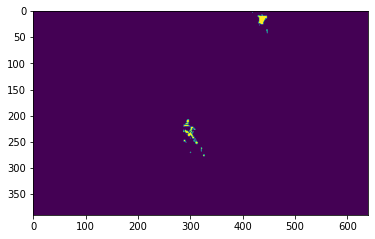

In [53]:
##### Threshold to differentiate objects of interest from background
img1 = cv2.cvtColor(img_ref, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(frames[1], cv2.COLOR_BGR2RGB)


mask = []
mask_uint8 = []
kernel = np.ones((10, 10), np.uint8)
large = np.ones((6, 6), np.uint8)
small = np.ones((2, 2), np.uint8)
kernel_large = cv2.getStructuringElement(cv2.MORPH_CROSS,(10, 10))
kernel_small = cv2.getStructuringElement(cv2.MORPH_CROSS,(5, 5))


for frame in frames:
  mask.append(cv2.absdiff(frame, img_ref).max(axis=2) > 90)
  mask_uint8.append(np.where(mask[-1], np.uint8(255), np.uint8(0)))

plt.imshow(mask[250])

Application of morpholical operators to the thresholded images to remove noise and imperfections. These images will be carried through a connected components analysis. At the end we show the same frame after morpholigcal operation. Included are a 3 square kernels of increasing size and 2 cross-shaped kernels. These kernels were all tested to attempt to find an operation that provided the best results for centroid tracking. After some trial and error, we determined two iterations of dilation with a large cross-shaped kernel worked best in filling in the holes of the mask. We also show the dilated image of the same mask shown in the above coding block to confirm correct dilation.

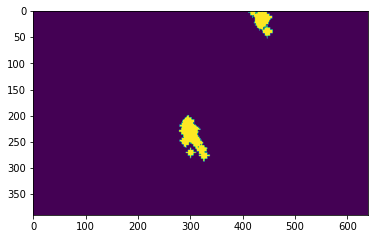

In [54]:
##### apply morphological operators to the thresholded images in order to remove noise and imperfections.
for i in range(1, len(frames)):
  mask_uint8[i] = cv2.dilate(mask_uint8[i], kernel_large,iterations = 2)

plt.imshow(mask_uint8[250])

Here we create a display to be used in for our tracking using connected components. This display contains the outline of the tennis court to make it easier to follow the centroid tracking.

In [55]:
### makes display and draws tennis lines

image = mask_uint8[300]
display = np.full((image.shape[0], image.shape[1], 3),255,
                          dtype='uint8')
### vertical lines
cv2.line( display, make_point([20,380]), make_point([100,75]),
                      (0,0,0), 2, cv2.LINE_AA )
cv2.line( display, make_point([600,380]), make_point([520,75]),
                      (0,0,0), 2, cv2.LINE_AA )

cv2.line( display, make_point([100,380]), make_point([170,75]),
                      (0,0,0), 2, cv2.LINE_AA )
cv2.line( display, make_point([520,380]), make_point([450,75]),
                      (0,0,0), 2, cv2.LINE_AA )

cv2.line( display, make_point([310,290]), make_point([310,150]),
                      (0,0,0), 2, cv2.LINE_AA )
#net
cv2.line( display, make_point([20,220]), make_point([20,185]),
                      (0,0,0), 2, cv2.LINE_AA )
cv2.line( display, make_point([600,220]), make_point([600,185]),
                      (0,0,0), 2, cv2.LINE_AA )

### horizontal
cv2.line( display, make_point([20,380]), make_point([600,380]),
                      (0,0,0), 2, cv2.LINE_AA )
cv2.line( display, make_point([520,75]), make_point([100,75]),
                      (0,0,0), 2, cv2.LINE_AA )

cv2.line( display, make_point([115,290]), make_point([500,290]),
                      (0,0,0), 2, cv2.LINE_AA )
cv2.line( display, make_point([150,150]), make_point([470,150]),
                      (0,0,0), 2, cv2.LINE_AA )
#net
cv2.line( display, make_point([20,220]), make_point([600,220]),
                      (0,0,0), 2, cv2.LINE_AA )
cv2.line( display, make_point([20,185]), make_point([600,185]),
                      (0,0,0), 2, cv2.LINE_AA )

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

Here we use our get_coordinates function to create an array of coordinates of the centroids for each player over time. These are stored in the p1 and p2 arrays. These points are then added to our created display via a forloop, allowing us to show the total movement of the player throughout the rally.

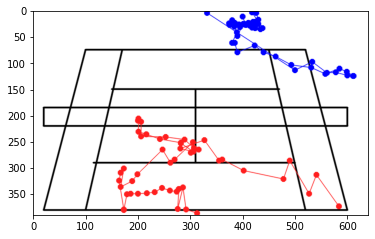

In [56]:
all_contours = []

#gets coordinates for the locations of the players
for i in range(0, len(mask_uint8) - 20, 10):
  all_contours.append(get_coordinates(mask_uint8[i]))

p1 = all_contours[0][0]
p2 = all_contours[0][-1]


### plots locations of tennis players and the path they follow
for coord in all_contours:
  cv2.circle( display, make_point(coord[0]), 3, (255,30,30),
                        3, cv2.LINE_AA )
  cv2.line( display, make_point(coord[0]), make_point(p1),
                      (255,30,30), 1, cv2.LINE_AA )
  p1 = coord[0]

  cv2.circle( display, make_point(coord[-1]), 3, (0,0,255),
                        3, cv2.LINE_AA )
  cv2.line( display, make_point(coord[-1]), make_point(p2),
                      (0,0,255), 1, cv2.LINE_AA )
  p2 = coord[-1]

for frame in frames:
    writer.write(frame)

cap.release()
plt.imshow(display)

# Written Report

To create our tracking system of two tennis players, we first needed to find a video sufficient enough to perform tracking on. While the traditional from-behind method of recording a tennis match is sufficient, many cameras did not remain stable throughout the rally and would cause issues in background subtracting. After finding a video with a stable background, we were able to crop it to include just the court and the two players, removing the potential for noise from the crowd or ball boys. This resulted in a 526 frame video for tracking. We performed temporal averaging to extract the background, and created a mask to separate the players from the court background. We had hoped to track the ball as well, but size issues made it impossible to track. These thresholded masks showed the players only, but had some gaps to fill to create two objects to track. To do this, we performed dilation using morphological operators with a cross shaped kernel to represent an approximate shape of a person. This filled gaps found between the players bodies and their head or feet. We then used a user defined function based adapted from the capture_ipynb notebook provided to capture the coordinates of the centroids of the contours over time and plot them on a display that mapped the tennis court from the video. Here you are able to see our "cool factor" how the players traversed the court over time on the mapped tennis court in our display. Due to the angle of the video, there are some times where the closer player to the camera appears on the other side of the net, however that is an issue with depth. A better, more accurate method would have been to track the two players from a birds-eye-view directly above the court, however no such video could be found for a professional match. 

Overall our code and approach is effective at tracking two tennis players throughout a rally. We believe this code would work in tracking players in any singles game, and minimal changes would need to be made to track a doubles match due to how we track our contours. This notebook could also likely work with any class of data tracking two people or objects moving in a frame such as a race. This code might run into issues if a player is wearing a shirt that is a similar color to the court. We did have some slight issues in tracking the players that appeared to have no significant impact on the result. At times the legs of the player were not able to be abstracted in our thresholding, leading the mask to appear more as a blob than in the shape of a person. In our contour tracking this led to no issues, but might lead to slight innacuracies in the calculation of the centroids, or create masks that don't resemble two players being isolated.

Our results are shown in the blocks below, including plots of three different frames, the masks created, and the masks after dilation using a double iterated cross-shaped kernel, as well as the finished plot of the tracked players.

Plot 1: The plots shown below include the first frame, the mask create from thresholding, and the mask after dilation

Text(0.5, 1.0, 'Mask After Dilation')

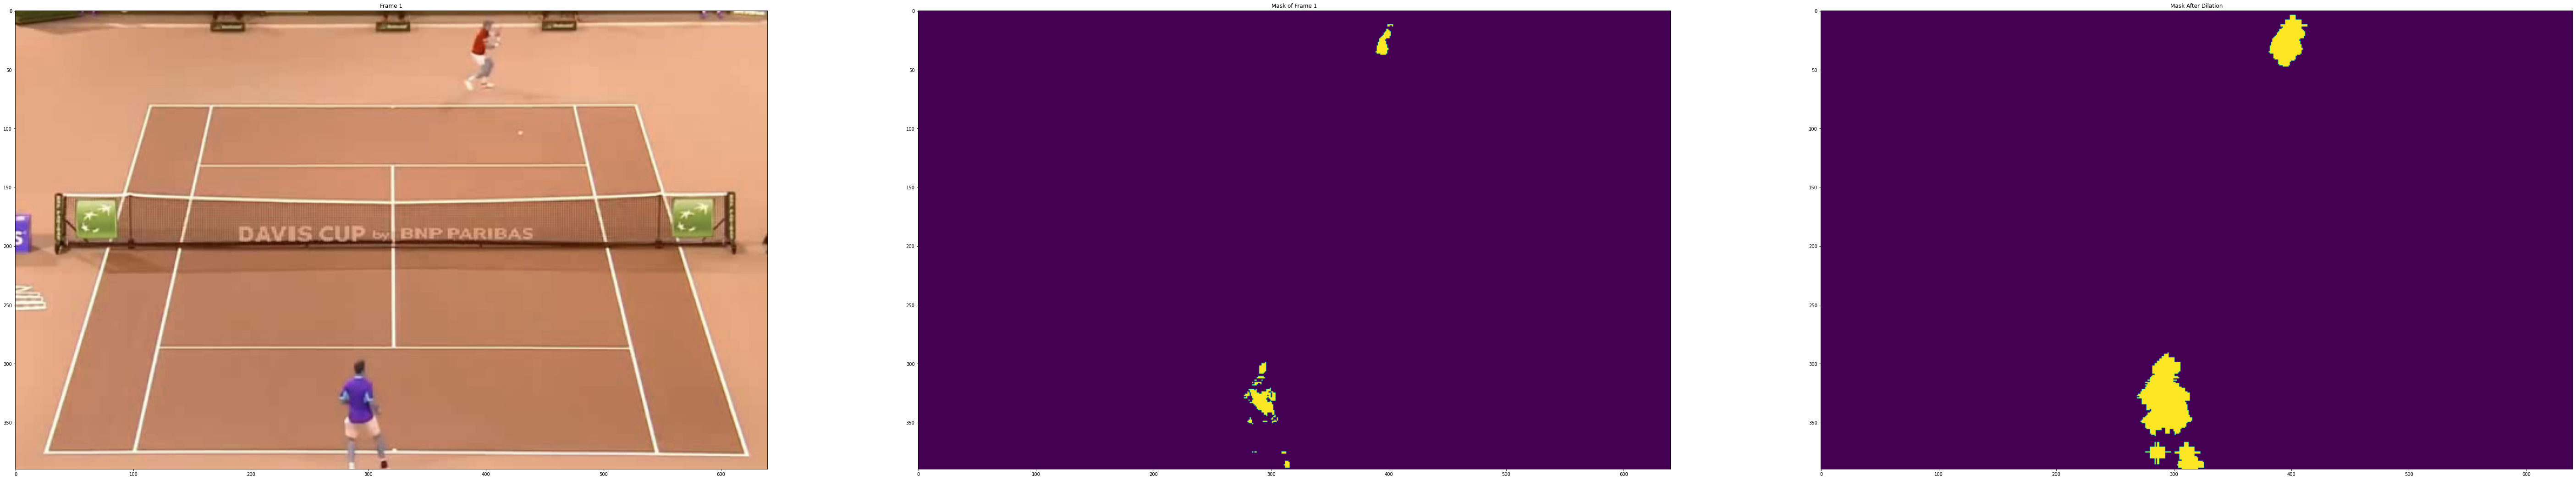

In [57]:
plt.figure(figsize=(100,30))

plt.subplot(1,3,1)
plt.imshow(frames[1],)
plt.title('Frame 1')

plt.subplot(1,3,2)
plt.imshow(mask[1])
plt.title('Mask of Frame 1')

plt.subplot(1,3,3)
plt.imshow(mask_uint8[1])
plt.title('Mask After Dilation')

Plot 2: The plots shown below include the 300th frame, the mask create from thresholding, and the mask after dilation

Text(0.5, 1.0, 'Mask After Dilation')

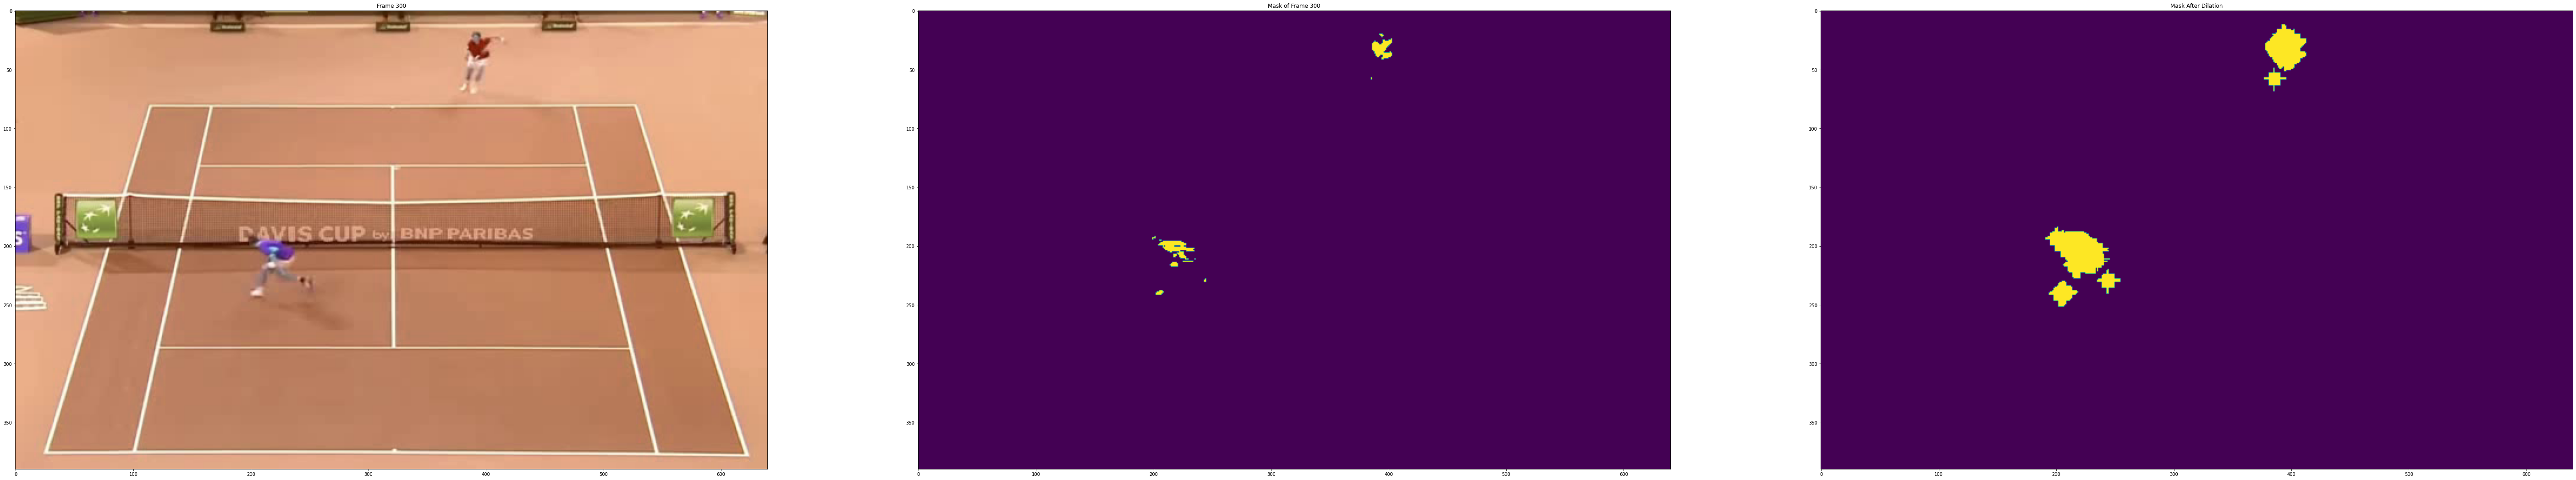

In [58]:
plt.figure(figsize=(100,30))

plt.subplot(1,3,1)
plt.imshow(frames[300])
plt.title('Frame 300')

plt.subplot(1,3,2)
plt.imshow(mask[300])
plt.title('Mask of Frame 300')

plt.subplot(1,3,3)
plt.imshow(mask_uint8[300])
plt.title('Mask After Dilation')

Plot 3: The plots shown below include the final frame, the mask create from thresholding, and the mask after dilation

Text(0.5, 1.0, 'Mask After Dilation')

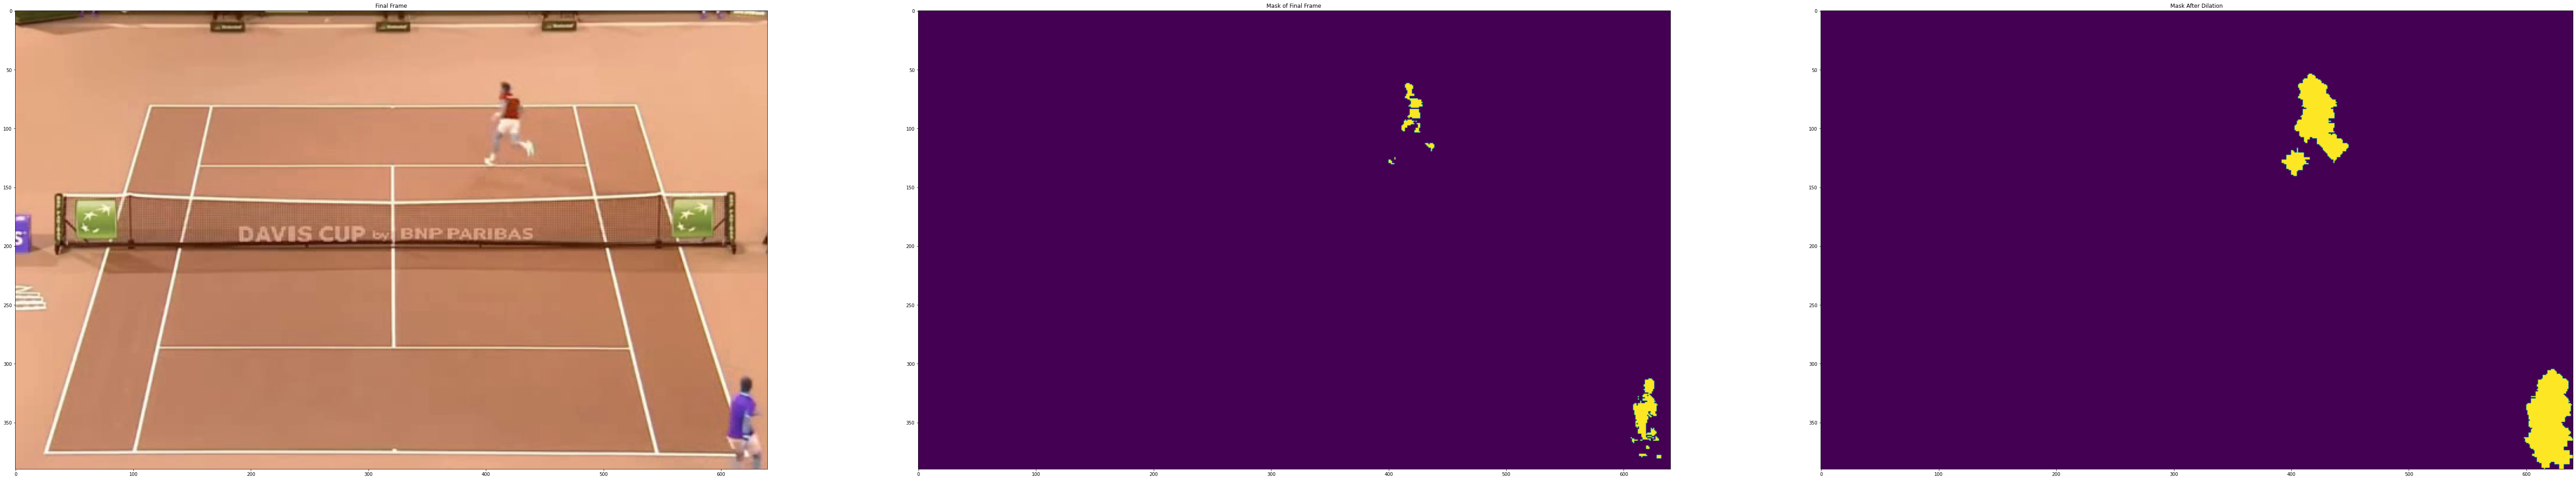

In [59]:
plt.figure(figsize=(100,30))

plt.subplot(1,3,1)
plt.imshow(frames[525])
plt.title('Final Frame')

plt.subplot(1,3,2)
plt.imshow(mask[525])
plt.title('Mask of Final Frame')

plt.subplot(1,3,3)
plt.imshow(mask_uint8[525])
plt.title('Mask After Dilation')


PLot 4: The plot shown below is our resultant plot of centroid tracking overlaid over the tennis court outline for each player.

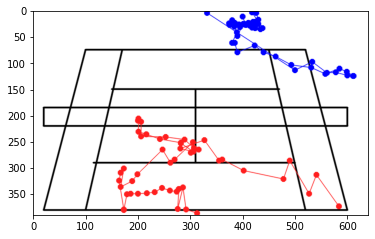

In [60]:
plt.imshow(display)